# Heston SLV 

- Example of using CppFM in Python
- Arbitrary volatility surface, for example U-shape.

In [1]:
%matplotlib inline

import cppfm
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import time

print(f"CppFM version: {cppfm.__version__}")

CppFM version: 0.1.0


## 1. Market Data Setup

Define the volatility surface from market implied volatilities.

In [2]:
# Risk-free rate
r = 0.05
curve = cppfm.FlatDiscountCurve(r)

# Spot price
S0 = 100.0

# Market volatility surface data
strikes = [80, 85, 90, 95, 100, 105, 110, 115, 120]
maturities = [0.08, 0.25, 0.5, 1.0, 2.0]  # 1M, 3M, 6M, 1Y, 2Y

# Implied volatility matrix - U-shaped smile (typical equity)
# Shape: [len(maturities), len(strikes)]
ivs = [
    [0.28, 0.25, 0.23, 0.215, 0.21, 0.215, 0.23, 0.25, 0.28],  # 1M 
    [0.26, 0.235, 0.215, 0.205, 0.20, 0.205, 0.215, 0.235, 0.26],  # 3M
    [0.25, 0.225, 0.205, 0.195, 0.19, 0.195, 0.21, 0.23, 0.26],  # 6M
    [0.24, 0.215, 0.195, 0.185, 0.18, 0.185, 0.20, 0.22, 0.25],  # 1Y
    [0.23, 0.205, 0.185, 0.175, 0.17, 0.175, 0.19, 0.21, 0.24],  # 2Y
]

# Create volatility surface
vol_surface = cppfm.VolatilitySurface(
    strikes, maturities, ivs, curve,
    cppfm.SmileInterpolation.CubicSpline,
    cppfm.MaturityInterpolation.ForwardMoneyness
)

print(f"Surface bounds: {vol_surface.get_bounds()}")
print(f"ATM 1Y IV: {vol_surface.implied_volatility(100, 1.0):.2%}")
print(f"Local vol at (S=100, t=0.5): {vol_surface.local_volatility(100, 0.5):.2%}")

Surface bounds: ((80.0, 120.0), (0.08, 2.0))
ATM 1Y IV: 18.00%
Local vol at (S=100, t=0.5): 16.75%


## 1.1 SVI Calibration

Calibrate SVI (Stochastic Volatility Inspired) smile to each maturity slice.

SVI parameterization (Gatheral 2004):
```
w(k) = a + b * (rho*(k-m) + sqrt((k-m)^2 + sigma^2))
```
where:
- `w = sigma^2 * T` (total variance)
- `k = log(K/F)` (log-moneyness)
- `a, b, rho, m, sigma` are parameters

Constraints for no arbitrage:
- `b >= 0`
- `-1 < rho < 1`
- `sigma > 0`
- `a + b*sigma*sqrt(1-rho^2) >= 0` (non-negative wings)

In [3]:
from scipy.optimize import least_squares
from dataclasses import dataclass
from typing import Optional, Tuple, List
import warnings

@dataclass
class SVIParams:
    """SVI smile parameters"""
    a: float      # vertical shift
    b: float      # overall slope
    rho: float    # rotation (-1, 1)
    m: float      # horizontal shift
    sigma: float  # curvature at ATM
    
    def total_variance(self, k: float) -> float:
        """w(k) = a + b*(rho*(k-m) + sqrt((k-m)^2 + sigma^2))"""
        x = k - self.m
        return self.a + self.b * (self.rho * x + np.sqrt(x*x + self.sigma**2))
    
    def implied_vol(self, K: float, F: float, T: float) -> float:
        """Convert to implied volatility"""
        k = np.log(K / F)
        w = self.total_variance(k)
        if w <= 0:
            return 0.001  # floor
        return np.sqrt(w / T)
    
    def is_arbitrage_free(self) -> bool:
        """Check basic no-arbitrage conditions"""
        if self.b < 0:
            return False
        if abs(self.rho) >= 1:
            return False
        if self.sigma <= 0:
            return False
        # wing condition: a + b*sigma*sqrt(1-rho^2) >= 0
        wing_check = self.a + self.b * self.sigma * np.sqrt(1 - self.rho**2)
        if wing_check < 0:
            return False
        return True


def svi_calibrate(strikes: np.ndarray, ivs: np.ndarray, F: float, T: float,
                  initial_guess: Optional[SVIParams] = None) -> Tuple[SVIParams, dict]:
    """
    Calibrate SVI to a single smile slice.
    Uses scipy.optimize.least_squares (Levenberg-Marquardt).
    """
    k = np.log(strikes / F)
    w_market = ivs**2 * T  # target: total variance
    
    # initial guess
    if initial_guess is None:
        atm_idx = np.argmin(np.abs(k))
        w_atm = w_market[atm_idx]
        x0 = [w_atm * 0.8, 0.1, -0.3, 0.0, 0.1]  # a, b, rho, m, sigma
    else:
        x0 = [initial_guess.a, initial_guess.b, initial_guess.rho, 
              initial_guess.m, initial_guess.sigma]
    
    def residuals(params):
        a, b, rho, m, sigma = params
        x = k - m
        w_model = a + b * (rho * x + np.sqrt(x*x + sigma**2))
        return w_model - w_market
    
    # bounds: b >= 0, -1 < rho < 1, sigma > 0
    lb = [-np.inf, 0.0, -0.999, -0.5, 1e-4]
    ub = [np.inf, 2.0, 0.999, 0.5, 1.0]
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        result = least_squares(residuals, x0, bounds=(lb, ub), method='trf',
                               ftol=1e-10, xtol=1e-10, max_nfev=500)
    
    a, b, rho, m, sigma = result.x
    params = SVIParams(a=a, b=b, rho=rho, m=m, sigma=sigma)
    
    # compute fit quality
    w_fit = np.array([params.total_variance(ki) for ki in k])
    iv_fit = np.sqrt(w_fit / T)
    rmse = np.sqrt(np.mean((iv_fit - ivs)**2))
    max_err = np.max(np.abs(iv_fit - ivs))
    
    info = {
        'rmse': rmse,
        'max_error': max_err,
        'converged': result.success,
        'iterations': result.nfev,
        'arbitrage_free': params.is_arbitrage_free()
    }
    return params, info


In [4]:
# Calibrate SVI to each maturity slice
strikes_arr = np.array(strikes)
svi_results = {}

print("Calibrating SVI to each maturity slice...")
print("-" * 70)

for i, T_mat in enumerate(maturities):
    F = S0 * np.exp(r * T_mat)  # forward price
    ivs_slice = np.array(ivs[i])
    
    params, info = svi_calibrate(strikes_arr, ivs_slice, F, T_mat)
    svi_results[T_mat] = (params, info)
    
    arb_flag = "OK" if info['arbitrage_free'] else "FAIL"
    print(f"T={T_mat:.2f}y: RMSE={info['rmse']*10000:.1f}bp  "
          f"MaxErr={info['max_error']*10000:.1f}bp  Arb={arb_flag}")
    print(f"         a={params.a:.4f} b={params.b:.4f} rho={params.rho:.3f} "
          f"m={params.m:.4f} sigma={params.sigma:.4f}")

print("-" * 70)

Calibrating SVI to each maturity slice...
----------------------------------------------------------------------
T=0.08y: RMSE=7.6bp  MaxErr=13.3bp  Arb=OK
         a=-0.0629 b=0.1960 rho=0.719 m=0.5000 sigma=0.4872
T=0.25y: RMSE=7.7bp  MaxErr=12.4bp  Arb=OK
         a=-0.1602 b=0.5096 rho=0.726 m=0.5000 sigma=0.4855
T=0.50y: RMSE=7.6bp  MaxErr=12.4bp  Arb=OK
         a=-0.2675 b=1.4171 rho=0.827 m=0.5000 sigma=0.3586
T=1.00y: RMSE=8.1bp  MaxErr=13.4bp  Arb=OK
         a=-0.4326 b=1.9299 rho=0.768 m=0.3988 sigma=0.3764
T=2.00y: RMSE=9.2bp  MaxErr=15.7bp  Arb=OK
         a=-0.5051 b=1.9999 rho=0.628 m=0.1893 sigma=0.3616
----------------------------------------------------------------------


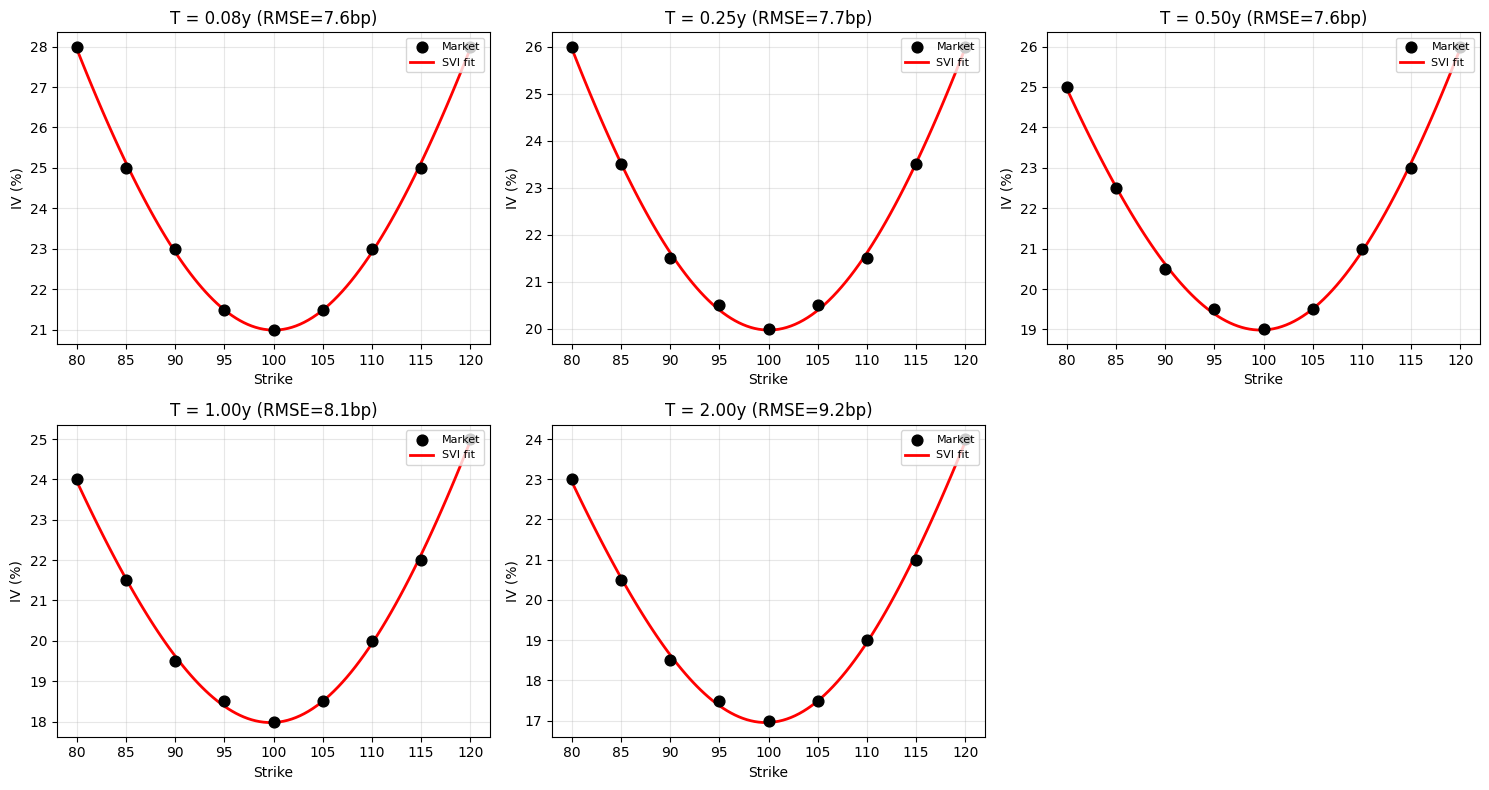

In [5]:
# Visualize SVI fit vs market data
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, T_mat in enumerate(maturities):
    if idx >= len(axes):
        break
    
    ax = axes[idx]
    F = S0 * np.exp(r * T_mat)
    ivs_market = np.array(ivs[idx])
    params, info = svi_results[T_mat]
    
    # fine grid for smooth SVI curve
    k_fine = np.linspace(np.log(strikes[0]/F), np.log(strikes[-1]/F), 100)
    K_fine = F * np.exp(k_fine)
    iv_svi = np.array([params.implied_vol(K, F, T_mat) for K in K_fine])
    
    # market points
    ax.scatter(strikes_arr, ivs_market * 100, c='black', s=60, zorder=5, label='Market')
    # SVI fit
    ax.plot(K_fine, iv_svi * 100, 'r-', lw=2, label='SVI fit')
    
    ax.set_xlabel('Strike')
    ax.set_ylabel('IV (%)')
    ax.set_title(f'T = {T_mat:.2f}y (RMSE={info["rmse"]*10000:.1f}bp)')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

# hide unused subplot
if len(maturities) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.show()


SVI provides smooth, arbitrage-free interpolation of market quotes.

## 2. Heston Model Setup

Create the Heston stochastic volatility model.

In [ ]:
# Heston model parameters
# Adjusted for better U-shaped smile compatibility:
# - Higher sigma_v for wing curvature
# - Less negative rho for more symmetry
v0 = 0.04       # Initial variance (20% vol)
kappa = 1.0     # Mean reversion (slower allows more variance movement)
vbar = 0.04     # Long-term variance
sigma_v = 0.5   # Vol-of-vol (higher -> more smile curvature)
rho = -0.4      # Correlation (less negative -> less skew, more U-shape)

heston = cppfm.HestonModel(
    spot=S0,
    discount_curve=curve,
    v0=v0,
    kappa=kappa,
    vbar=vbar,
    sigma_v=sigma_v,
    rho=rho
)

print(heston)
print(f"Feller condition satisfied: {heston.satisfies_feller()}")
print(f"  2*kappa*vbar = {2*kappa*vbar:.4f}")
print(f"  sigma_v^2    = {sigma_v**2:.4f}")
if not heston.satisfies_feller():
    print("  (Feller violated - QE scheme handles V->0 correctly)")

<HestonModel S0=100.000000 v0=0.040000 kappa=1.000000 vbar=0.040000 sigma_v=0.500000 rho=-0.400000>
Feller condition satisfied: False
  2*kappa*vbar = 0.0800
  sigma_v^2    = 0.2500
  (Feller violated - QE scheme handles V->0 correctly)


WARNING [HestonModel]: Feller condition NOT satisfied!
  Required: 2*κ*v̄ ≥ σ²_v
  Current:  2*1*0.04 = 0.08 < σ²_v = 0.25
  Implication: Variance process can reach zero.
  Use appropriate discretization schemes (BK/QE, BK/TG) that handle V->0.



## 3. Vol Smile Fitting: Pure Heston vs HestonSLV with SVI Surface

Using the SVI-calibrated surface from Section 1.1 to demonstrate HestonSLV fitting.

Pipeline: **Market quotes -> SVI calibration -> Smooth surface -> HestonSLV**

The SVI surface provides:
- Smooth interpolation between market points
- Arbitrage-free extrapolation in wings
- Well-behaved local volatility via Dupire

In [7]:
# Simulation parameters
n_paths = 300_000   # increased from 100k - better E[V|S] at wings
n_steps = 200       # steps per year
seed = 42

# Build external VolatilitySurface from SVI calibration
# Use finer strike grid for smoother local vol

test_T = 0.5  # target maturity for comparison
test_strikes = np.array([85, 90, 95, 100, 105, 110, 115])

# Generate IVs from SVI for all slices
# Use wider strike range for better surface construction
svi_strike_grid = list(np.linspace(80, 120, 17))  # 17 strikes
svi_maturities = [0.25, 0.5, 1.0]
svi_vols = []

for T_mat in svi_maturities:
    F = S0 * np.exp(r * T_mat)
    # use SVI params from closest calibrated maturity
    closest_T = min(svi_results.keys(), key=lambda t: abs(t - T_mat))
    svi_params, _ = svi_results[closest_T]
    
    row = [svi_params.implied_vol(K, F, T_mat) for K in svi_strike_grid]
    svi_vols.append(row)
    print(f"T={T_mat:.2f}: using SVI from T={closest_T:.2f}, ATM IV = {row[8]*100:.2f}%")

# Build the SVI-based volatility surface
svi_surface = cppfm.VolatilitySurface(
    svi_strike_grid, svi_maturities, svi_vols, curve
)
print(f"\nSVI surface created: {len(svi_strike_grid)} strikes x {len(svi_maturities)} maturities")

# Get market IVs at test strikes for comparison
F_test = S0 * np.exp(r * test_T)
closest_T = min(svi_results.keys(), key=lambda t: abs(t - test_T))
svi_params_test, _ = svi_results[closest_T]
market_ivs = np.array([svi_params_test.implied_vol(K, F_test, test_T) for K in test_strikes])
print(f"\nTarget T={test_T}: market IVs = {market_ivs * 100}")

T=0.25: using SVI from T=0.25, ATM IV = 19.98%
T=0.50: using SVI from T=0.50, ATM IV = 18.99%
T=1.00: using SVI from T=1.00, ATM IV = 17.98%

SVI surface created: 17 strikes x 3 maturities

Target T=0.5: market IVs = [22.53132683 20.61828113 19.38488656 18.98617678 19.50809541 20.92559407
 23.12359009]


In [8]:
# Pure Heston MC (no SLV leverage)
# With adjusted params (sigma_v=0.5, rho=-0.4), pure Heston should
# produce some curvature, but still won't perfectly match U-shaped target

test_steps = list(np.linspace(0, test_T, int(test_T * n_steps) + 1))
heston_sim = cppfm.HestonSLVSimulator(heston, test_steps, n_paths, 25, seed)
# NO calibration = L=1 everywhere = pure Heston dynamics
heston_terminals = heston_sim.simulate()

heston_ivs = []
for K in test_strikes:
    payoff_sum = sum(max(s - K, 0) for s, _ in heston_terminals)
    mc_price = np.exp(-r * test_T) * payoff_sum / n_paths
    iv = cppfm.bs_implied_volatility(S0, K, r, test_T, mc_price, cppfm.OptionType.Call)
    heston_ivs.append(iv)
heston_ivs = np.array(heston_ivs)
print(f"Pure Heston MC IVs: {heston_ivs * 100}")
print(f"  (params: sigma_v={sigma_v}, rho={rho})")

Pure Heston MC IVs: [22.98494055 21.50462255 20.05259427 18.72639817 17.70535839 17.19903547
 17.20704095]
  (params: sigma_v=0.5, rho=-0.4)


In [9]:
# HestonSLV with SVI-calibrated surface
# Leverage function adjusts Heston dynamics to match the SVI smile

slv_sim = cppfm.HestonSLVSimulator(
    heston, 
    svi_surface,  # SVI-calibrated VolatilitySurface
    test_steps, 
    n_paths, 
    num_bins=50,  # was 30 - finer resolution, ~6000 paths/bin
    seed=seed
)

# calibrate leverage function
iters = slv_sim.calibrate_leverage(
    max_iters=100,  # was 50 - allow full convergence
    tol=1e-4,       # was 5e-4 - stricter stopping criterion
    damping=0.5     # was 0.6 - more aggressive leverage updates
)
print(f"SLV calibration converged in {iters} iterations")

slv_terminals = slv_sim.simulate()

slv_ivs = []
for K in test_strikes:
    payoff_sum = sum(max(s - K, 0) for s, _ in slv_terminals)
    mc_price = np.exp(-r * test_T) * payoff_sum / n_paths
    iv = cppfm.bs_implied_volatility(S0, K, r, test_T, mc_price, cppfm.OptionType.Call)
    slv_ivs.append(iv)
slv_ivs = np.array(slv_ivs)
print(f"SLV MC IVs (SVI):   {slv_ivs * 100}")

SLV calibration converged in 13 iterations
SLV MC IVs (SVI):   [20.16785289 19.55290689 19.17681455 19.07268096 19.2719726  19.76510338
 20.48999106]


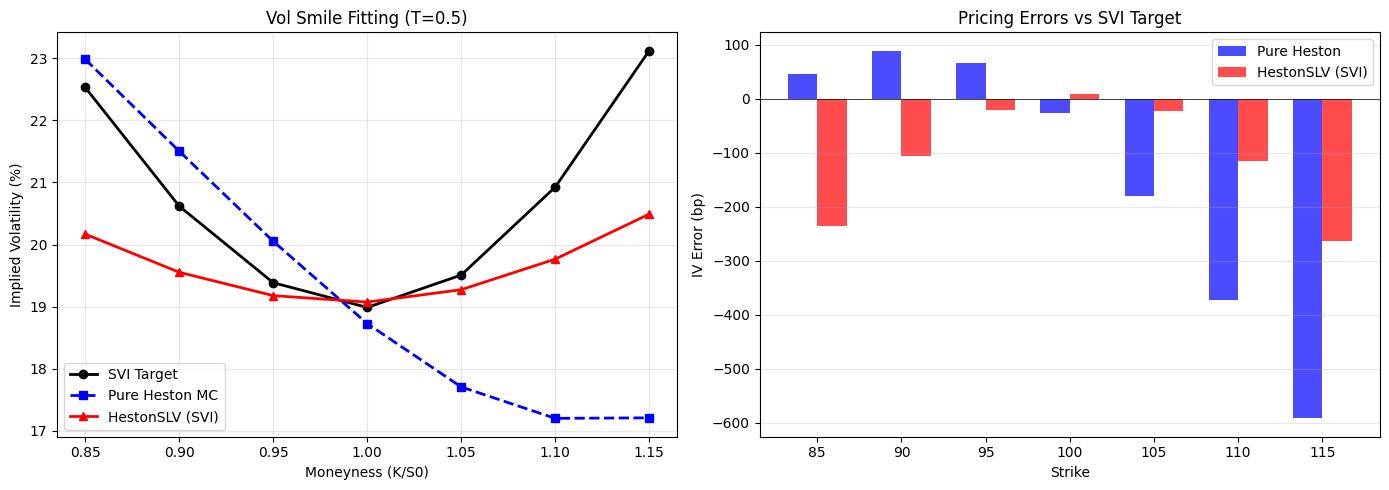


Max |error| Pure Heston: 591.7 bp
Max |error| HestonSLV:   263.4 bp

Pipeline: Market quotes -> SVI calibration -> Smooth surface -> HestonSLV


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Vol smile comparison
ax = axes[0]
moneyness = test_strikes / S0
ax.plot(moneyness, market_ivs * 100, 'k-', lw=2, marker='o', label='SVI Target')
ax.plot(moneyness, heston_ivs * 100, 'b--', lw=2, marker='s', label='Pure Heston MC')
ax.plot(moneyness, slv_ivs * 100, 'r-', lw=2, marker='^', label='HestonSLV (SVI)')
ax.set_xlabel('Moneyness (K/S0)')
ax.set_ylabel('Implied Volatility (%)')
ax.set_title(f'Vol Smile Fitting (T={test_T})')
ax.legend()
ax.grid(True, alpha=0.3)

# Error comparison
ax = axes[1]
heston_errors = (heston_ivs - market_ivs) * 10000
slv_errors = (slv_ivs - market_ivs) * 10000

x = np.arange(len(test_strikes))
width = 0.35
ax.bar(x - width/2, heston_errors, width, label='Pure Heston', color='blue', alpha=0.7)
ax.bar(x + width/2, slv_errors, width, label='HestonSLV (SVI)', color='red', alpha=0.7)
ax.axhline(0, color='black', lw=0.5)
ax.set_xlabel('Strike')
ax.set_ylabel('IV Error (bp)')
ax.set_title('Pricing Errors vs SVI Target')
ax.set_xticks(x)
ax.set_xticklabels([f'{k:.0f}' for k in test_strikes])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nMax |error| Pure Heston: {np.max(np.abs(heston_errors)):.1f} bp")
print(f"Max |error| HestonSLV:   {np.max(np.abs(slv_errors)):.1f} bp")
print(f"\nPipeline: Market quotes -> SVI calibration -> Smooth surface -> HestonSLV")

Why is this data not fittable?
- How would we do this in FX?
    - Maybe this surface is not arbFree. -> needs SSVI
    